<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Image-Classification/blob/main/Image_classification_with_ConvMixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with ConvMixer on the CIFAR-10 dataset

**Author:** [Ashaduzzaman Piash](
https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 19/06/2024
<br>
**Reference:**
- [MLP-Mixer: An all-MLP Architecture for Vision](
https://doi.org/10.48550/arXiv.2105.01601)
- [Patches Are All You Need?](https://openreview.net/pdf?id=TVHS5Y4dNvM)

## Introduction

### **Vision Transformers (ViT)**:
  - **Process**: Extract small patches from images, linearly project them, apply Transformer blocks.
  - **Advantage**: Eliminate the need for strong inductive biases like convolutions.
  - **Flexibility**: Capable of learning from training data with minimal inductive priors.
  - **Performance**: Achieve great results with proper regularization, data augmentation, and large datasets.
  - **Application**: Promising area for image recognition tasks.

### **Patches Are All You Need Paper**:
  - **Extension**: Use patches to train an all-convolutional network.
  - **Architecture**: ConvMixer.
  - **Techniques**: Incorporates ideas from ViT and MLP-Mixer like isotropic architecture, residual connections, same depth and resolution across layers.
  - **Results**: Demonstrates competitive performance.

### **Implementation Example**:
  - **Goal**: Implement ConvMixer and test its performance on the CIFAR-10 dataset.

## Imports

In [2]:
# Upgrade to keras 3
! pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 24.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras import layers

## Hyperparameters

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10

## Load the CIFAR-10 dataset

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
val_split = 0.1

val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]

print(f'Training data samples: {len(new_x_train)}')
print(f'Validation data samples: {len(x_val)}')
print(f'Test data samples: {len(x_test)}')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data samples: 45000
Validation data samples: 5000
Test data samples: 10000


## Prepare tf.data.Dataset objects

In [6]:
image_size = 32
auto = tf.data.AUTOTUNE  # Automatic tuning for dataset performance

# Define the augmentation layers
augmentation_layers = [
    keras.layers.RandomCrop(image_size, image_size),
    keras.layers.RandomFlip('horizontal'),
]

# Apply augmentation layers to the images
def augment_images(images):
  for layer in augmentation_layers:
    images = layer(images, training=True)
  return images

# Create a TensorFlow dataset from the images and labels
def make_datasets(images, labels, is_train=False):
  dataset = tf.data.Dataset.from_tensor_slices((images, labels))

  # Shuffle the dataset if it is for training
  if is_train:
    dataset = dataset.shuffle(batch_size * 10)

  # Batch the dataset
  dataset = dataset.batch(batch_size)

  # Apply augmentation to the dataset in parallel
  if is_train:
    dataset = dataset.map(
        lambda x, y: (augment_images(x), y), num_parallel_calls=auto
    )

  # Prefetch the dataset for performance optimization
  return dataset.prefetch(auto)

# Create training, validation, and test datasets
train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

## ConvMixer utilities

**ConvMixer**:
  - **ConvLayers**: Uses standard convolution layers instead of fully-connected layers.
  - **BatchNorm**: Utilizes BatchNorm instead of LayerNorm.
  
**Types of Convolutions in ConvMixer**:
  - **Depthwise Convolutions**: Mix spatial locations of the images.
  - **Pointwise Convolutions**: Follow depthwise convolutions to mix channel-wise information across patches.
  
**Key Feature**:
- Uses larger kernel sizes to enable a larger receptive field.
- In this experiment ConvMixer-256/8 where 256 denotes the number of channels and 8 denotes the depth


![](https://i.imgur.com/yF8actg.png)

In [7]:
def activation_block(x):
  x = layers.Activation('gelu')(x)
  return layers.BatchNormalization()(x)

def conv_stem(x, filters: int, patch_size: int):
  x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
  return activation_block(x)

def conv_mixer_block(x, filters: int, kernel_size: int):
  # Depthwise Convolution
  x0 = x
  x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding='same')(x)
  x = layers.Add()([activation_block(x), x0])  # Residual Block

  # Pointwise Convolution
  x = layers.Conv2D(filters, kernel_size=1)(x)
  x = activation_block(x)

  return x

def get_conv_mixer_256_8(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10
):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks
    for _ in range(depth):
      x = conv_mixer_block(x, filters, kernel_size)

    # Classification block
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

## Model training and Evaluation utility

In [8]:
def run_experiment(model):
  # Initialize the AdamW optimizer with specified learning rate and weight decay
  optimizer = keras.optimizers.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay
  )

  # Compile the model with the optimizer, loss function, and evaluation metrics
  model.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
  )

  # Define the file path for saving the best model
  checkpoint_filepath = '/tmp/checkpoint.keras'

  # Create a callback to save the best model based on validation accuracy
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor='val_accuracy',
      save_best_only=True,
      save_weights_only=False,
  )

  # Create a callback to save the best model based on validation accuracy
  history = model.fit(
      train_dataset,
      validation_data=val_dataset,
      epochs=num_epochs,
      callbacks=[checkpoint_callback],
  )

  # Load the best weights after training
  model.load_weights(checkpoint_filepath)

  # Evaluate the model on the test dataset
  _, accuracy = model.evaluate(test_dataset)

  # Print the test accuracy
  print(f'Test Accuracy: {round(accuracy * 100, 2)}%')

  return history, model

## Train and evaluate model

In [11]:
# Initialize the ConvMixer model
conv_mixer_model = get_conv_mixer_256_8()

# Run the experiment with the ConvMixer model
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 1056s 3s/step - accuracy: 0.4592 - loss: 1.4830 - val_accuracy: 0.1034 - val_loss: 4.3533
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 989s 3s/step - accuracy: 0.6981 - loss: 0.8492 - val_accuracy: 0.6972 - val_loss: 0.8788
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 970s 3s/step - accuracy: 0.7728 - loss: 0.6402 - val_accuracy: 0.7320 - val_loss: 0.8233
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 967s 3s/step - accuracy: 0.8233 - loss: 0.5073 - val_accuracy: 0.7790 - val_loss: 0.6656
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 974s 3s/step - accuracy: 0.8550 - loss: 0.4175 - val_accuracy: 0.8206 - val_loss: 0.5608
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 973s 3s/step - accuracy: 0.8796 - loss: 0.3557 - val_accuracy: 0.7794 - val_loss: 0.7169
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 985s 3s/step - accuracy: 0.8980 - loss: 0.3026 - val_accuracy: 0.8150 - val_loss: 0.5842
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 973s 3s/step - accuracy: 0.9122 - loss: 0.2587 - val_acc

## Visualizing the internals of ConvMixer

### Visualization of the patch embeddings and the learned convolution filters

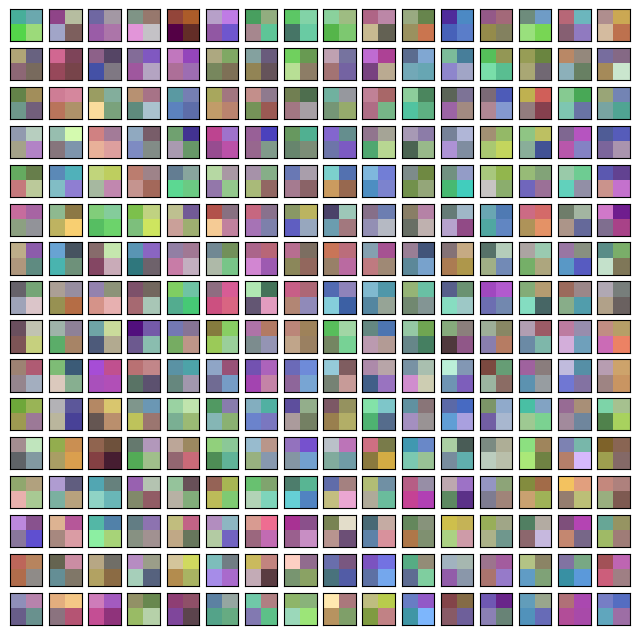

In [12]:
def visualization_plot(weights, idx=1):
  '''
  To avoid isotrophic scaling, apply min-max normalization
  to the given weights
  '''
  p_min, p_max = weights.min(), weights.max()
  weights = (weights - p_min) / (p_max - p_min)

  # Visualize all the filters
  num_filters = 256
  plt.figure(figsize=(8, 8))

  for i in range(num_filters):
    current_weight = weights[:, :, :, i]
    if current_weight.shape[-1] == 1:
      current_weight = current_weight.squeeze()
    ax = plt.subplot(16, 16, idx)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(current_weight)
    idx += 1

# We first visualize the learned patch embeddings
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

### Visualization of the the raw convolution kernels

5 <DepthwiseConv2D name=depthwise_conv2d_8, built=True>
12 <DepthwiseConv2D name=depthwise_conv2d_9, built=True>
19 <DepthwiseConv2D name=depthwise_conv2d_10, built=True>
26 <DepthwiseConv2D name=depthwise_conv2d_11, built=True>
33 <DepthwiseConv2D name=depthwise_conv2d_12, built=True>
40 <DepthwiseConv2D name=depthwise_conv2d_13, built=True>
47 <DepthwiseConv2D name=depthwise_conv2d_14, built=True>
54 <DepthwiseConv2D name=depthwise_conv2d_15, built=True>


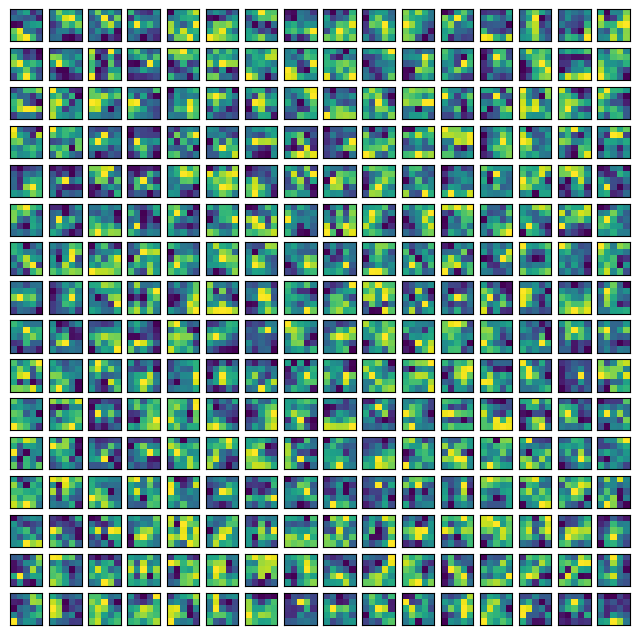

In [13]:
# First, print the indices of the convolution layers that are not pointwise convolutions.
for i, layer in enumerate(conv_mixer_model.layers):
  if isinstance(layer, layers.DepthwiseConv2D):
    if layer.get_config()['kernel_size'] == (5, 5):
      print(i, layer)

idx = 26  # Taking a kernel from middle of the network

kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)